# Covid-19 Vaccines in California and their Impacts

## Data Cleaning and Exploration

In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import datetime as dt
import requests
from census import Census
from us import states
import json

#import API keys
from config import api_key
from config import gkey
c = Census(api_key)

### Cleaning Data

In [2]:
# Cleaning Cases Data
case_df = pd.read_csv("Data/covid19cases_test.csv")

# change date column to easier to compare format
case_df.date = pd.to_datetime(case_df['date'],format='%m/%d/%Y')

# filter out dates past 3-31-21, as well as rows with useless data
clean_case = case_df.loc[(case_df.date<dt.datetime(2021,4,1)) & \
                         (case_df.area != 'Out of state') & \
                         (case_df.area != 'California')& \
                         (case_df.area != 'Unknown')]

# filter out columns we dont need
clean_case = clean_case[['date','area','population','cases','deaths','total_tests','positive_tests']]

# Rename column for dataset consistency
clean_case = clean_case.rename(columns={'area': 'county'})

# replace missing data with 0
clean_case = clean_case.fillna(0)
clean_case.to_csv('Data/clean_case.csv', index=False)

clean_case.head()

,date,county,population,cases,deaths,total_tests,positive_tests
1403,2021-03-31,Alameda,1685886.0,98.0,1.0,10553.0,123.0
1404,2021-03-31,Alpine,1117.0,0.0,0.0,3.0,0.0
1405,2021-03-31,Amador,38531.0,3.0,0.0,317.0,8.0
1406,2021-03-31,Butte,217769.0,11.0,0.0,632.0,11.0
1407,2021-03-31,Calaveras,44289.0,4.0,0.0,80.0,4.0


In [3]:
# Cleaning Vaccinations Data
vaccine_df = pd.read_csv("Data/covid19vaccinesbycounty.csv")
vaccine_df.head()

# Dropping unneeded columns
vaccine_df=vaccine_df.drop(columns=['cumulative_pfizer_doses',
                         'cumulative_moderna_doses','cumulative_jj_doses',
                         'cumulative_at_least_one_dose', 'california_flag'])
vaccine_df=vaccine_df.drop(vaccine_df[(vaccine_df['county']=='All CA Counties')|
                                      (vaccine_df['county']=='All CA and Non-CA Counties')|
                                      (vaccine_df['county']=='Outside California')|
                                      (vaccine_df['county']=='Unknown')].index)

vaccine_df.to_csv('Data/vaccine_df.csv', index=False)

vaccine_df.head()

,county,administered_date,total_doses,cumulative_total_doses,pfizer_doses,moderna_doses,jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose
511,Alameda,12/15/2020,36,36,36,0,0,36,36,0,0,36
512,Alameda,12/16/2020,202,238,202,0,0,202,238,0,0,202
513,Alameda,12/17/2020,396,634,396,0,0,396,634,0,0,396
514,Alameda,12/18/2020,1766,2400,1765,1,0,1766,2400,0,0,1766
515,Alameda,12/19/2020,1357,3757,1357,0,0,1357,3757,0,0,1357


In [4]:
# Cleaning Hospital Data

In [5]:
# Cleaning Colleges Data
college_data = pd.read_csv('Data/ca_colleges.csv')

college_data.columns = ['School_ID', 'School_name', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'county', 'Longitude', 'Latitude', 'Total_Enrollment', 'Full_time_enrollment', 
                        'Part_time_enrollment']

college_data.drop(columns=['School_ID', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'Full_time_enrollment', 'Part_time_enrollment'], inplace=True)

college_data.county = college_data.county.map(lambda x: x[ :-7])
college_data.dropna(subset=['Total_Enrollment'], inplace=True)
college_data.to_csv('Data/college_data.csv', index=False)

college_data.head()

,School_name,county,Longitude,Latitude,Total_Enrollment
0,Academy of Art University,San Francisco,-122.400578,37.787943,9812.0
1,Academy of Chinese Culture and Health Sciences,Alameda,-122.269839,37.805972,133.0
3,Avalon School of Cosmetology-Alameda,Alameda,-122.243566,37.764203,47.0
4,College of Alameda,Alameda,-122.279303,37.781017,5667.0
5,Allan Hancock College,Santa Barbara,-120.421144,34.943716,11894.0


In [6]:
#Determining California fips code for API
states.CA.fips

# Obtaining US Census Data
census_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B17001_002E', 
                         'B01003_001E'), geo={'for': 'zip code tabulation area:*', 'in': 'state:06'})
census_data[0]

#Converting to DataFrame
census_df = pd.DataFrame(census_data)

census_df.rename(columns={'B19013_001E': 'Household_Income',
                         'B19301_001E': 'Income_per_Capita',
                         'B17001_002E': 'Poverty_Count', 
                         'B01003_001E': 'Population', 
                         'NAME': 'Name', 
                          'zip code tabulation area': 'Zipcode'}, inplace=True)
census_df = census_df.loc[census_df.Household_Income>0].copy()
census_df.drop(columns=['Name', 'Poverty_Count', 'state'], inplace=True)
census_df = census_df[['Zipcode', 'Household_Income', 'Income_per_Capita', 'Population']]

census_df.to_csv('Data/census_df.csv', index=False)
census_df.head()

,Zipcode,Household_Income,Income_per_Capita,Population
0,95126,92788.0,54954.0,35988.0
1,95134,139558.0,65665.0,27224.0
2,95202,14484.0,12408.0,6001.0
3,95209,78883.0,27963.0,44313.0
4,95222,52289.0,36554.0,5090.0


### Data Grouping

In [7]:
#Vaccines by Date:
ca_vaccinations=vaccine_df.groupby(['administered_date'],as_index=False).agg({'cumulative_total_doses':['sum']})
ca_vaccinations.columns = ca_vaccinations.columns.droplevel(1)
ca_vaccinations.administered_date = pd.to_datetime(ca_vaccinations['administered_date'],format='%m/%d/%Y')
ca_vaccinations['cumulative_doses_by_10000']=ca_vaccinations.apply(lambda row: row.cumulative_total_doses/10000,axis=1)

ca_vaccinations.to_csv('Data/ca_vaccinations.csv', index=False)
ca_vaccinations.head()

,administered_date,cumulative_total_doses,cumulative_doses_by_10000
0,2021-01-01,509458,50.9458
1,2021-01-10,973267,97.3267
2,2021-01-11,1080894,108.0894
3,2021-01-12,1193160,119.3160
4,2021-01-13,1311540,131.1540


In [8]:
# Cases by County:
cases_grouped = clean_case.groupby('county').agg({'cases': 'sum',
                                                  'deaths': 'sum',
                                                  'total_tests': 'sum',
                                                  'positive_tests': 'sum',
                                                  'population': 'max'})

cases_grouped['Cases per 100,000'] = (cases_grouped['cases']/cases_grouped['population']*100000).astype(int)

cases_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cases              58 non-null     float64
 1   deaths             58 non-null     float64
 2   total_tests        58 non-null     float64
 3   positive_tests     58 non-null     float64
 4   population         58 non-null     float64
 5   Cases per 100,000  58 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 2.9+ KB


In [9]:
# Vaccines by County:
vaccine_grouped = vaccine_df.groupby('county').agg({'total_doses': 'sum',
                                                  'cumulative_fully_vaccinated': 'max'})

vaccine_grouped['Fully Vaccinated per 100,000'] = (vaccine_grouped['cumulative_fully_vaccinated']/
                                                         cases_grouped['population']*100000).astype(int)

vaccine_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   total_doses                   58 non-null     int64
 1   cumulative_fully_vaccinated   58 non-null     int64
 2   Fully Vaccinated per 100,000  58 non-null     int32
dtypes: int32(1), int64(2)
memory usage: 1.6+ KB


Both cases_grouped and vaccines_grouped dataframes contain all 58 counties.

In [10]:
grouped_colleges = college_data.groupby('county')['Total_Enrollment'].sum().astype(int)
college_population = grouped_colleges.to_frame()

len(college_population)

41

41 of California's counties contain at least one college with student enrollment for the 2019-2020 school year.

#### Running geocodng API to obtain lat/lon values for counties

In [11]:
# Create a list of Counties included in data sets to use for geocoding API

counties = clean_case['county'].unique()

# Creating Lists to fill coordinates
lat = []
lng = []

# Set up for API call
base_url = 'https://maps.googleapis.com/maps/api/geocode/json?address='
    
for county in counties:
    target_county = f'{base_url}{county},+CA&key={gkey}'
    response = requests.get(target_county).json()
    try:
        lat.append(response['results'][0]['geometry']['location']['lat'])
        lng.append(response['results'][0]['geometry']['location']['lng'])
    except:
        print(f'{county} could not be located...Skipping')
        pass
print('Coordinates have been added to datasets.')

Coordinates have been added to datasets.


In [12]:
# Build county DF

county_dict = {'county': counties,
              'latitude': lat,
              'longitude': lng}
county_data = pd.DataFrame(county_dict)

county_data.set_index('county', inplace=True)
county_data['population'] = cases_grouped['population']
county_data['student_pop'] = college_population['Total_Enrollment']
county_data['cases per 100,000'] = cases_grouped['Cases per 100,000']
county_data['Fully Vaccinated per 100,000'] = vaccine_grouped['Fully Vaccinated per 100,000']
county_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   latitude                      58 non-null     float64
 1   longitude                     58 non-null     float64
 2   population                    58 non-null     float64
 3   student_pop                   41 non-null     float64
 4   cases per 100,000             58 non-null     int32  
 5   Fully Vaccinated per 100,000  58 non-null     int32  
dtypes: float64(4), int32(2)
memory usage: 2.7+ KB


In [72]:
county_data['student_pop'] = county_data['student_pop'].fillna(0)
county_data.reset_index(inplace=True)
county_data['% student population'] = round(county_data['student_pop']/county_data['population']*100,2)

county_data.to_csv('Data/county_data.csv', index=False)
county_data.head()

,index,county,latitude,longitude,population,student_pop,"cases per 100,000","Fully Vaccinated per 100,000",% student population
0,0,Alameda,37.779872,-122.282185,1685886.0,130485.0,4995,33949,7.74
1,1,Alpine,32.835052,-116.766411,1117.0,0.0,7699,53088,0.00
2,2,Amador,38.348892,-120.774093,38531.0,0.0,9311,25405,0.00
3,3,Butte,39.625395,-121.537000,217769.0,27274.0,5241,27251,12.52
4,4,Calaveras,38.196048,-120.680504,44289.0,0.0,4545,25898,0.00


### Statistics Analysis

In [70]:
# Finding outlier counties:

print('County Cases Outliers:')
x=county_data['cases per 100,000']
for cases in x:
    lower_bound = (x.quantile(0.25) - (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    upper_bound = (x.quantile(0.75) + (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    if cases < lower_bound or cases > upper_bound:
        outlier = cases
        outlier_county = county_data.loc[x == outlier]
        print('County: ' + outlier_county['county'].item() + ' ' + str(outlier))
    else:
        continue

    
print('\nCounty Vaccines Outliers:')
x=county_data['Fully Vaccinated per 100,000']
for vaccines in x:
    lower_bound = (x.quantile(0.25) - (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    upper_bound = (x.quantile(0.75) + (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    if vaccines < lower_bound or vaccines > upper_bound:
        outlier = vaccines
        outlier_county = county_data.loc[x == outlier]
        print('County: ' + outlier_county['county'].item() + ' ' + str(outlier))
    else:
        continue

County Cases Outliers:
County: Lassen 17026

County Vaccines Outliers:
County: Alpine 53088
County: Marin 46062
County: Mono 46379


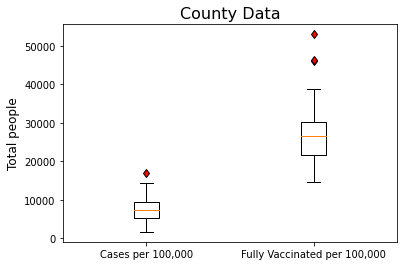

In [71]:
# Generate box plots
labels = ['Cases per 100,000', 'Fully Vaccinated per 100,000']
outliers = dict(markerfacecolor='red', marker='d')
plt.title('County Data', fontsize=16)
plt.ylabel('Total people', fontsize=12)
plt.boxplot([county_data['cases per 100,000'], county_data['Fully Vaccinated per 100,000']], labels=labels, 
            flierprops=outliers)
plt.show()